## Loading of Steinmetz data

includes some visualizations

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [2]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [47]:
#@title Helper Functions #427
import numpy as np
from sklearn.decomposition import PCA, SparsePCA
import matplotlib.pyplot as plt
from copy import deepcopy as cdc
np.set_printoptions(precision=3,floatmode="fixed") # set num of digits after decimal

def Clamp427(val,min_val,max_val):
   return max(min(val,max_val),min_val)

# Weber Fechner Law related function
def WF_filter427(vis_left,vis_right,base_val,diff,dir='UP'):
  """WF_filter based on the baseline value base_val & difference diff
  In this function left and right are indistinguishable
  Args:
    vis_left (1D np.arr of floats): contrast level for the left stimulus at each trial
    vis_right (1D np.arr of floats): contrast level for the right stimulus at each trial
    base_val (float): e.g., 0,0.25,0.5,1
    diff (float): e.g., 0,0.25,0.5,0.75,1
  KeyArg:
    dir (str):
      'UP': upward comparison: base_val is always the smaller value
      'DOWN': downward comparison: base_val is always the larger value
      'BI': bi-directional, base_val can be the smaller one or the larger one
  Return:
    boo (1D boolean np.arr): True if difference satistfies diff, and one of them is base_val
  """

  if dir=='BI': # bi-directional
    Boo1 = np.isclose(np.abs(vis_left-vis_right), diff, rtol=0) # difference check
    Boo2 = np.logical_or(np.isclose(vis_left, base_val, rtol=0),\
                            np.isclose(vis_right, base_val, rtol=0)) # base check
    return np.logical_and(Boo1,Boo2)
  else: # uni-directional
    LBaseBoo = np.isclose(vis_left, base_val, rtol=0) # left is base
    RBaseBoo = np.isclose(vis_right, base_val, rtol=0) # right is base
    if dir=='UP':
      LdiffBoo = np.isclose(vis_left + diff, vis_right, rtol=0)
      RdiffBoo = np.isclose(vis_right + diff, vis_left, rtol=0)
    elif dir=='DOWN':
      LdiffBoo = np.isclose(vis_left - diff, vis_right, rtol=0)
      RdiffBoo = np.isclose(vis_right - diff, vis_left, rtol=0)
    else:
      raise ValueError('<dir> keyword argument is unclear.')
    Boo1 = np.logical_and(LBaseBoo,LdiffBoo) # left case
    Boo2 = np.logical_and(RBaseBoo,RdiffBoo) # right case
    return np.logical_or(Boo1,Boo2) # left or right, hence indistinguishable

# variance explained hunting

def smoothDat(dat, kernel = None): # return a deep copy of dat by smoothening it using kernel
  if kernel == None: # define a gaussian kernel (mu=0, sigma=1)
    kernel = lambda x : 1/np.sqrt(2*np.pi)* np.exp(-x ** 2 /2.) # Guassian kernel
  dat_ = cdc(dat) # make a deep copy
  x = np.arange(-1, 1, 0.1) # size 20 filter
  for i in range(dat_['spks'].shape[0]):
    for j in range(dat_['spks'].shape[1]):
      dat_['spks'][i, j, :] = np.convolve(dat_['spks'][i, j, :], kernel(x), 'same')
  return dat_

def VarHunter427(dat, time_seg = None, nPC = 4, all_regions = True, regions_str = [] \
               , trial_seg = None, SPCA = False, trial_seg_isBoolMask = False):
  """ Given a session of data: dat
      print out variance explained using PCA/SparsePCA on spike data by brain sub-regions
  Args:
    dat (np.arr):
      dat = alldat[s] s:= session number
    time_seg (slice object): # first 80 bins = 1.6 sec
      specify the slice of time (3rd dim in dat['spks']) over which PCA is done
    nPC (int):
      number of principal components
    all_regions (bool):
      if True, do PCA on all neurons in that mouse in the session
      then time_seg is a list of slice objects instead of single slice when it is False
    regions_str (list of strings):
      if all_regions == True, then we do PCA only on those regions specified by regions_str
      if regions_str is empty (by default), then we literally do all regions
    trial_seg (nested lists): len(trial_seg) = nSlice
      if not None, then assume all_regions = True, and assume list of single time slice
      if not None, the list inside trial_seg should be indices of trials
    SPCA (bool):
      if Ture, do SparsePCA instead of PCA, but it takes a lot more time
    trial_seg_isBoolMask (bool):
      by default False, meaning trial_seg is a list of array-like object (not boolean mask)
      if True, trial_seg will be directly applied to mask the data
  Return:

  """
  nTimebins = dat['spks'].shape[-1] # number of bins
  nTrials = dat['spks'].shape[-2] # number of trials
  nN = dat['spks'].shape[0] # number of neurons
  brain_arr = list(set(dat['brain_area'])) # all unique brain_areas
  if not all_regions:
    if time_seg == None:
      time_seg == slice(51,130) # default
    list_var = list() # list of lists
    list_tot = list() # list of floats
    list_PC_NN = list() # list of len 2 tuples storing nPC and NN_
    for str_ in brain_arr: # iterate over all unique brain_areas
        filter_ = np.isin(dat['brain_area'], [str_])
        NN_ = filter_.sum()
        # stack all of the time bins along trials (collapse dim 1 and 2)
        droll = np.reshape(dat['spks'][filter_,:,time_seg], (NN_,-1))
        droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
        nPC = Clamp427(nPC, 0, min(droll.shape[0],droll.shape[1])) # 0: n_features, 1: n_samples
        model = PCA(n_components = nPC).fit(droll.T) if not SPCA \
          else SparsePCA(n_components = nPC).fit(droll.T)
        W = model.components_
        pc_10ms = W @ np.reshape(dat['spks'][filter_], (NN_,-1))
        pc_10ms = np.reshape(pc_10ms, (nPC, -1, nTimebins))
        variance_perc = model.explained_variance_ratio_
        tot_var = np.sum(variance_perc)
        list_var.append(variance_perc)
        list_tot.append(tot_var)
        list_PC_NN.append((nPC, droll.shape[0]))
    list_var = np.array(list_var)
    list_tot = np.array(list_tot)
    brain_arr = np.array(brain_arr)
    list_PC_NN = np.array(list_PC_NN)

    by_totnPC = np.argsort(list_tot)[::-1] # descending order
    list_var = list_var[by_totnPC]
    list_tot = list_tot[by_totnPC]
    brain_arr = brain_arr[by_totnPC]
    list_PC_NN = list_PC_NN[by_totnPC]
    for i in range(len(list_tot)):
        print('region: ', brain_arr[i].ljust(5), 'PC:n_features ' \
              , list_PC_NN[i][0], ':', str(list_PC_NN[i][1]).ljust(4) \
              , 'total: %.3f' %list_tot[i], 'var explained: ', list_var[i])
  else: # on all regions
    if len(regions_str) > 0: # if 0, use brain_arr = all regions
      brain_arr = regions_str
    rfilter_ = np.isin(dat['brain_area'], brain_arr) # neurosn in all regions in regions_str
    rSubset = dat['brain_area'][rfilter_] # subset of neurons whose regions show in regions_str
    nN = len(rSubset) # nN is subset only if regions_str does not contain all regions
    flag_TrialWise = False
    if not trial_seg == None: # assume time_seg is not empty and of single time slice
      nSlice = len(trial_seg)
      # make a list of bool filters corresponding to array like object inside trial_seg
      if not trial_seg_isBoolMask:
        filters_ = [np.isin(np.arange(nTrials), trial_seg[i]) \
                    for i in range(nSlice)]
      else: # of course if it is already boolean mask, just change variable name
        filters_ = trial_seg
      flag_TrialWise = True
      # convert list into boolean mask if time_seg[0] is not a slice object; ignore [1:]
      if not isinstance(time_seg[0], slice):
        time_seg[0] = np.isin(np.arange(nTimebins), time_seg[0])
    elif time_seg == None:
      # make time bin slices with a const stepsize
      stepsize = 10 # (every 10 bins; nTimebins has to be divisible by stepsize)
      time_seg = [slice(stepsize * i, stepsize * (i+1)) for i in range(nTimebins // stepsize)]
      nSlice = len(time_seg)
    else:
      nSlice = len(time_seg)
    PCperSlice = np.zeros((nSlice, nPC, nN)) # principal axes 3D np.arr (nSlice, nPC, n_features)
    varperSlice = np.zeros((nSlice, nPC)) # variance each PC explained
    for i in range(nSlice):
      droll = np.reshape(dat['spks'][rfilter_][:,:,time_seg[i]], (nN,-1)) if not flag_TrialWise \
         else np.reshape(dat['spks'][rfilter_][:,filters_[i],time_seg[0]], (nN,-1))
      droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
      nPC = Clamp427(nPC, 0, min(droll.shape[0],droll.shape[1])) # 0: n_features, 1: n_samples
      model = PCA(n_components = nPC).fit(droll.T) if not SPCA \
        else SparsePCA(n_components = nPC).fit(droll.T)
      PCperSlice[i,:,:] = model.components_
      varperSlice[i,:] = model.explained_variance_ratio_
    
    # group neurons by brain regions and collapse PC weights in that region
    PCperSlice_regions = {} # store results using different aggregation methods
    methods = [np.mean, np.sum, np.amax, np.std]
    methodsStr = ['mean', 'sum', 'max', 'std']
    for m in range(len(methods)):
      PCperSlice_regions_ = np.zeros((nSlice, nPC, len(brain_arr)))
      for i in range(len(brain_arr)): # iterate over all unique brain_areas / or those in regions_str only
        filter_ = np.isin(rSubset, [brain_arr[i]])
        PCperSlice_regions_[:,:,i] = methods[m](PCperSlice[:,:,filter_], axis = 2)
      PCperSlice_regions[methodsStr[m]] = PCperSlice_regions_
    return brain_arr, PCperSlice, PCperSlice_regions, varperSlice
  
def BrainRegions427(alldat, nestedSort = True):
  """ Given alldat: see returns for the purpose of this function
  Args:
    alldat (1D np.arr):
      contains len(alldat) sessions of dat
    nestedSort (bool):
      if True:
        temp & sessionList is sorted by the num of sessions region showed up
        items inside sessionList is sorted by number of neurons in the region
  Return (all np.arr):
    temp, sessionList, neuronNumList: (sorted by num of sessions)
    temp =        ['region4',              'region2', ...]
    sessionList =  [[0,    1,  2,10],      [4, 2,7], ...]
    neuronNumList = [[427, 42, 7, 2],      [10,9,8], ...]
    so basically: region i's name: temp[i];
                  it showed up in these sessions: sessionList[i]
                  each session has these numbers of neurons: neuronNumList[i]
  """
  temp = set()
  for s in range(len(alldat)):
    temp = (set(alldat[s]['brain_area']) | temp) # | is union operator
  temp = np.array(list(temp))
  # find session indices the region showed up
  sessionList = list()
  neuronNumList = list()
  for str_ in temp:
    sessionList.append(np.array([s for s in range(len(alldat)) if str_ in alldat[s]['brain_area']]))
    neuronNumList.append(np.array([sum([1 for j in alldat[i]['brain_area'] if j == str_]) \
                          for i in sessionList[-1]]))
  # convert to np.arr
  temp = np.array(temp)
  sessionList = np.array(sessionList)
  neuronNumList = np.array(neuronNumList)
  if nestedSort: # sort temp by number of sessions they appeared in
    Mask_ = np.argsort([len(i) for i in sessionList])[::-1]
    temp = temp[Mask_]
    sessionList = sessionList[Mask_]
    neuronNumList = neuronNumList[Mask_]
    for i in range(len(temp)): # sort sessionList[i] by number of neurons from region i
      Mask_ = np.argsort(neuronNumList[i])[::-1]
      sessionList[i] = sessionList[i][Mask_]
      neuronNumList[i] = neuronNumList[i][Mask_]
  return temp, sessionList, neuronNumList

def trialPreprocessing427(dat):
  """ Given a session of data: dat
      
  Args:
    dat (np.arr):
      dat = alldat[s] s:= session number
  Return:

  """
  pass
  # subset of correct trials, because 0 is not taken into consideration
  # 0 contains two types: 0 is solution (correct) and 0 is not responding (wrong)
  #is_correct = np.logical_and( np.sign(response)==np.sign(vis_left-vis_right),\
  #                             response != 0 )

def HeatMapTSegXBrainReg(PCperSlice_regions, brain_arr \
                       , choice_PC = [0,1,2,3], x_arr = [], x2_arr = []):
  """
    Args:
    PCperSlice_regions (np.arr; (nSlice, nPC, len(brain_arr)):
      nSlice: slice of data on which PCA is performed (x-axis of the heatmaps)
      nPC: number of PC = number of heatmaps
      len(brain_arr): number of regions after collapsing all neurons into subgroups
    brain_arr (list):
      string name for brain regions / or str(index) for each neuron in given region
      (in the latter case the y-axis will just be all neurons in given region)
      size of which should be equal to the PCperSlice_regions.shape[2]
    choice_PC (1D array like object):
      PC index to display heat map on
    x_arr (list of strings): e.g., ['hiContrast', 'loContrast']
      x-axis labels; len(x_arr) = PCperSlice_regions.shape[0]
    x2_arr (2D array; (nSlice, nPC)):
      similar to x_arr, but displayed variance, positioned on top of each plot
  """
  xLen = PCperSlice_regions.shape[0] # x is time segment slices
  yLen = PCperSlice_regions.shape[2] # y is brain region
  
  #fig, ax = plt.subplots() # create a plot; figsize: WidthxHeight, buggy
  fig, axs = plt.subplots(1, len(choice_PC), figsize=(26.4, 3)) # for 3 regions
  #fig, axs = plt.subplots(1, len(choice_PC) + 1, figsize=(28, 10)) # all regions
  # do min(4,nPC) components
  for pc in range(len(choice_PC)):
    theMatrix = PCperSlice_regions[:,choice_PC[pc],:].T # transpose it
    im = axs[pc].imshow(theMatrix)
    # show all ticks & labels
    """
    # Create colorbar
    cbar_kw = {}
    cbar = fig.colorbar(im, ax=axs[pc], **cbar_kw)
    cbar.ax.set_ylabel('PC weights', rotation=-90, va="bottom")
    """
    axs[pc].set_xticks(np.arange(xLen))
    axs[pc].set_yticks(np.arange(yLen))
    if not x_arr: # if x_arr is empty, which is by default
      x_arr = [str(i) for i in range(xLen)]
    axs[pc].set_xticklabels(x_arr)
    axs[pc].set_yticklabels(brain_arr)
    # Rotate the tick labels and set their alignment
    plt.setp(axs[pc].get_xticklabels(), rotation=70, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    """
    for y in range(yLen): # row of theMatrix
        for x in range(xLen): # col of theMatrix
            text = axs[pc].text(x, y, theMatrix[y, x],
                          ha="center", va="center", color="w")
    """
    if len(x2_arr) > 0: # make a second x-label
      ax2 = axs[pc].twiny()
      ax2.set_xticks(np.arange(xLen))
      ax2.set_xticklabels(x2_arr[:, pc].round(decimals = 3).astype(str)) # round & cast
      plt.setp(ax2.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
    axs[pc].set_title("PC {p:.0f}".format(p = choice_PC[pc] + 1))
  # Create colorbar
  clb = fig.colorbar(im, ax=axs.ravel().tolist(), shrink = 0.42)
  clb.ax.set_ylabel('PC weights', rotation=-90, va="bottom")
  clb.ax.set_anchor((1,0.5))
  #fig.tight_layout()
  plt.show()

def listSlices(start, end, step = 1):
  """
  Make a list of slices specified by the start and end and step size
  for the last slice, its end is clamped to end: e.g., (68,69) when end = 69 and step >= 2
  but also last slice won't be (x,x) (i.e., 0-size slice)
  Args:
    start, end, step (int)
  """
  temp = list()
  currentStart = start # initialize current starting point in slice()
  while currentStart < end:
    temp.append(slice(currentStart, Clamp427(currentStart + step, 0, end)))
    currentStart += step
  return temp


raw session 0:
raw session 0:  sum


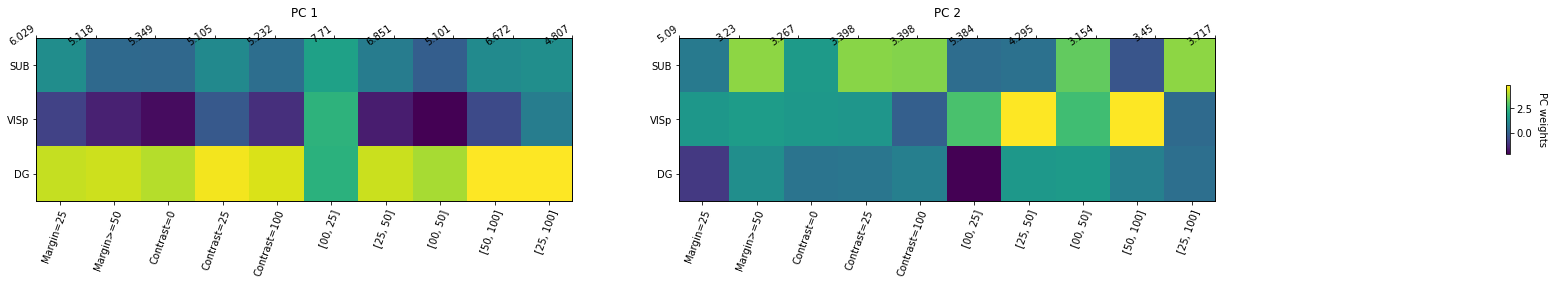

raw session 19:
raw session 19:  sum


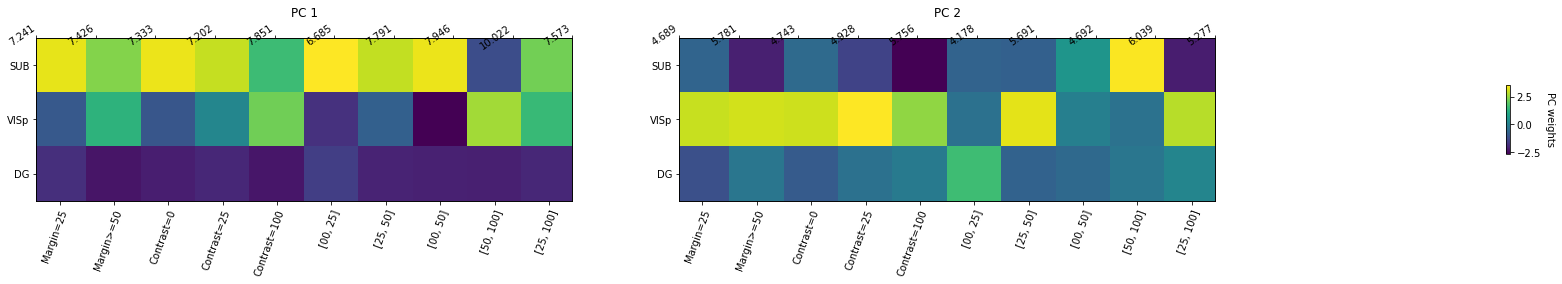

raw session 11:
raw session 11:  sum


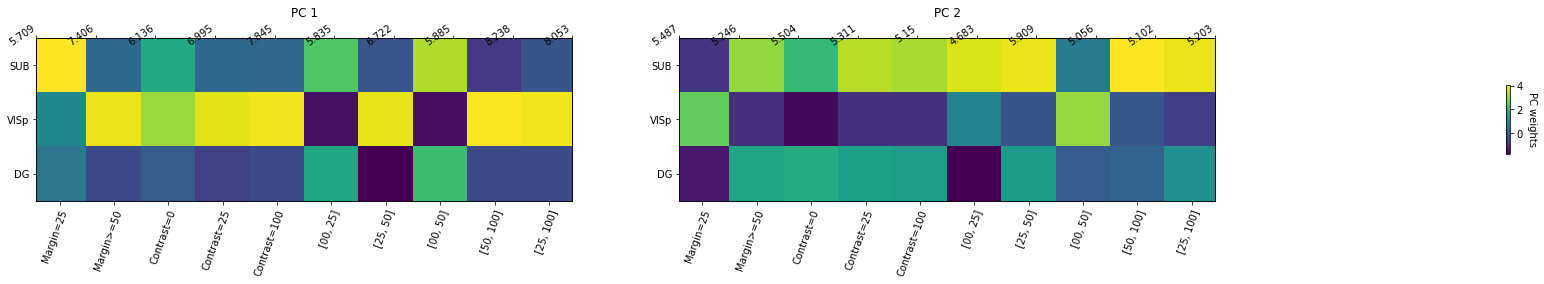

raw session 7:
raw session 7:  sum


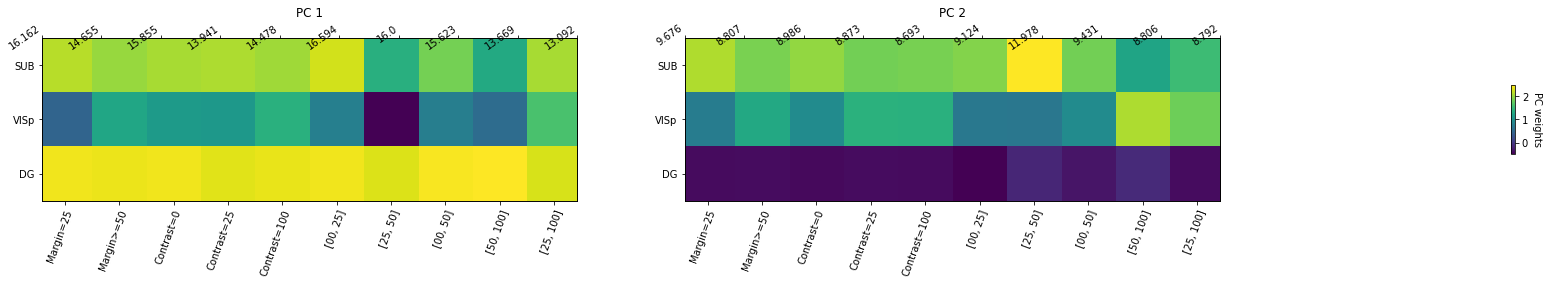

raw session 3:
raw session 3:  sum


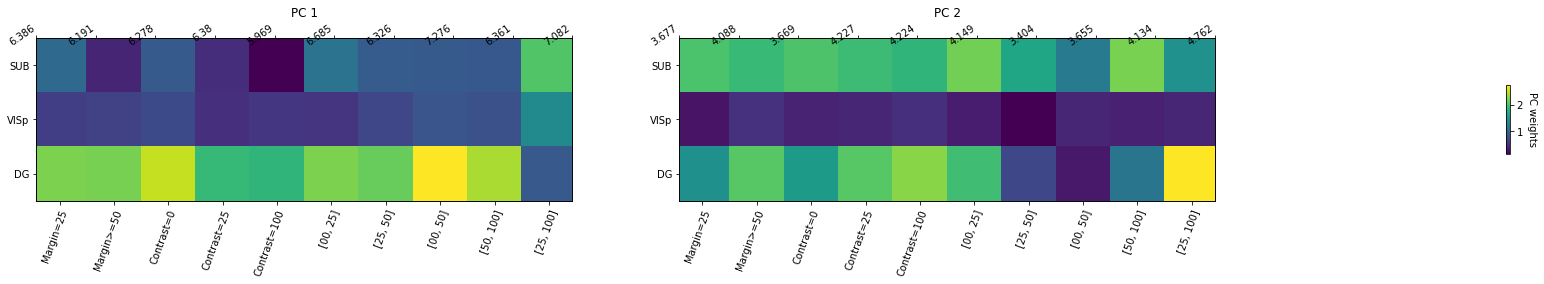

raw session 38:
raw session 38:  sum


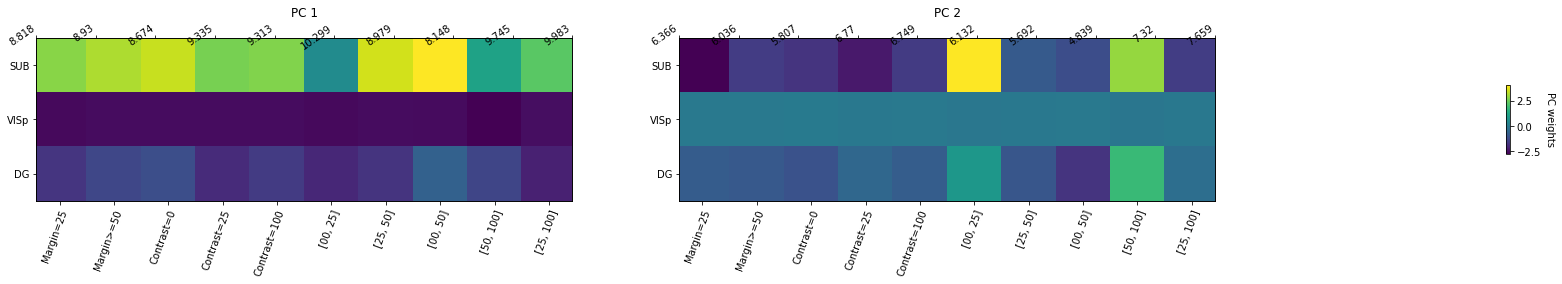

SUB
[ 3 11  4 38  0 29 18 19  7]
[108 105 101  93  75  61  57  51  34]
VISp
[ 0 25 21 19  2  9 24 11  7 13  3 38]
[178 162 133 122 114 105  94  66  48  42  39  15]
DG
[ 3 22  9 38 29 11 19 18  2  0  7 34 26 12  4 27]
[144  75  73  69  67  65  45  41  34  34  33  28  20  17  16  15]
sessions containing all 3 regions: SUB, VISp, DG: {0, 3, 38, 7, 11, 19}


In [48]:
sessions_PCA = [0, 19, 11, 7, 3, 38] # all have SUB, VISp, and DG (VISp neuron counts descending)
methodsStr = ['mean', 'sum', 'max', 'std'] # only mean & sum are used
time_seg = [slice(51,75)]
for s in sessions_PCA:
  response = alldat[s]['response'] # right - nogo - left (-1, 0, 1)
  vis_right = alldat[s]['contrast_right'] # 0 - low - high
  vis_left = alldat[s]['contrast_left'] # 0 - low - high
  is_correct = np.logical_and( np.sign(response)==np.sign(vis_left-vis_right),\
                              response != 0 )
  # CD = Contrast difference = Margin
  loCD_0025 = WF_filter427(vis_left, vis_right, 0.0, 0.25) # {0,25}
  loCD_2550 = WF_filter427(vis_left, vis_right, 0.25, 0.25) # {25,50}
  hiCD_0050 = WF_filter427(vis_left, vis_right, 0, 0.5) # {0,50}
  hiCD_50100 = WF_filter427(vis_left, vis_right, 0.5, 0.5) # {50,100}
  veryhiCD_25100 = WF_filter427(vis_left, vis_right, 0.25, 0.75) # {25,100}

  loMargin = WF_filter427(vis_left,vis_right,0.25,0.25,dir='BI')
  hiMargin = np.any((WF_filter427(vis_left,vis_right,0.50,0.50,dir='BI') \
                   , WF_filter427(vis_left,vis_right,1.0,0.75,dir='DOWN') \
                   , WF_filter427(vis_left,vis_right,1.0,1.0,dir='DOWN')), axis = 0)

  nullC = np.any((WF_filter427(vis_left,vis_right,0.0,0.25,dir='UP') \
                , WF_filter427(vis_left,vis_right,0.0,0.50,dir='UP') \
                , WF_filter427(vis_left,vis_right,0.0,1.0,dir='UP')), axis = 0)
  loC = np.any((WF_filter427(vis_left,vis_right,0.25,0.25,dir='BI') \
              , WF_filter427(vis_left,vis_right,0.25,0.75,dir='UP')), axis = 0)
  hiC = np.any((WF_filter427(vis_left,vis_right,1.0,0.50,dir='DOWN') \
              , WF_filter427(vis_left,vis_right,1.0,0.75,dir='DOWN') \
              , WF_filter427(vis_left,vis_right,1.0,1.0,dir='DOWN')), axis = 0)
  
  clm = np.logical_and(is_correct, loMargin)
  chm = np.logical_and(is_correct, hiMargin)
  iclm = np.logical_and(~is_correct, loMargin)
  ichm = np.logical_and(~is_correct, hiMargin)
  #trial_seg = [is_correct, ~is_correct, loMargin, hiMargin, clm, chm, iclm, ichm]
  trial_seg = [loMargin, hiMargin, nullC, loC, hiC \
             , loCD_0025, loCD_2550, hiCD_0050, hiCD_50100, veryhiCD_25100]
  x_arr = ['Margin=25', 'Margin>=50', 'Contrast=0', 'Contrast=25', 'Contrast=100' \
         , '[00, 25]', '[25, 50]' \
         , '[00, 50]', '[50, 100]' \
         , '[25, 100]']
  print('raw session %0.f:' %s)
  brain_arr, _, PCperSlice_regions, varperSlice = \
    VarHunter427(alldat[s], time_seg = time_seg, nPC = 2, trial_seg = trial_seg, trial_seg_isBoolMask = True, regions_str = ['SUB', 'VISp', 'DG'])
  # make percentage by multiplying it by 100
  varperSlice = varperSlice * 100
  for i in [1]: # use only sum
    print('raw session %0.f:' %s, ' %s' %methodsStr[i])
    HeatMapTSegXBrainReg(PCperSlice_regions[methodsStr[i]], brain_arr \
                       , choice_PC = [0,1], x_arr = x_arr, x2_arr = varperSlice)

brainRegions, sessionList, neuronNumList = BrainRegions427(alldat)
setlist = list()
for i in [12, 4, 3]: # SUB, VISp, DG
  # session 11, 19, 38 show up in all three regions
  print(brainRegions[i])
  print(sessionList[i])
  print(neuronNumList[i])
  setlist.append(set(sessionList[i]))
print('sessions containing all 3 regions: SUB, VISp, DG:', setlist[0].intersection(setlist[1],setlist[2]))

`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 


